## Analyzing problem regimes for (1D Reaction PDE)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch

### Understanding the Logistic Growth Curve Across ρ Values

To guide our PINN training setup, we first visualize how the **1-D reaction solution** changes with different values of ρ:

$$
\frac{du}{dt} = \rho \cdot u \cdot (1 - u), \quad u(0) = u_0
$$

with the initial condition:

$$
u(x,0)=exp(\frac{-(x-\pi)^2}{2(\pi/4)^2})
$$

Its analytical solution is:

$$
u(t) = \frac{h(x) \cdot e^{\rho t}}{1 + h(x) \cdot \left(e^{\rho t} - 1\right)}
$$

where h(x) is the function of the initial condition

This helps us:
- Identify **qualitative regimes** (slow, moderate, fast growth).
- Choose a **representative ρ interval** for training.
- Decide how many ρ points are needed to capture the diversity of dynamics.

Below, we plot the solution $u(t)$ for a range of ρ values, $t \in [0, 1]$ and $x \in [0, 2\pi]$.

In [37]:
def reaction_solution(x, t, rho, u0=0.1):
    h = np.exp(- (x - np.pi)**2 / (2 * (np.pi / 4)**2))
    return h * np.exp(rho * t) / (h * np.exp(rho * t) + 1 - h)

t = np.linspace(0, 1, 200)
x = np.linspace(0, 2*np.pi, 200)

T, X = np.meshgrid(t, x, indexing='ij')  # Create meshgrid

torch.from_numpy(x).float()
rho_groups = {
    "Low (slow growth)": [0.1, 0.3, 0.5],
    "Medium (balanced growth)": [1.0, 2.0, 3.0],
    "High (fast/stiff growth)": [5.0, 10.0, 20.0],
}

<Figure size 1200x600 with 0 Axes>

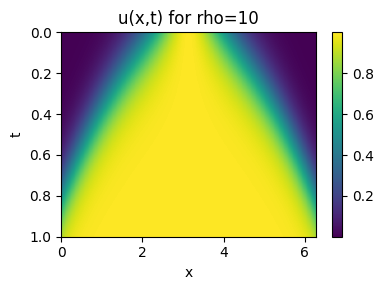

In [38]:
# Distinct line styles for each regime
line_styles = {
    "Low (slow growth)": 'solid',
    "Medium (balanced growth)": 'dashed',
    "High (fast/stiff growth)": 'dotted'
}


plt.figure(figsize=(12, 6))
rho=10
'''
for label, rho_vals in rho_groups.items():
    style = line_styles[label]
    for rho in rho_vals:
        u = logistic_solution(t, rho)
        plt.plot(t, u, linestyle=style, label=f"rho = {rho} ({label})")
'''
u= reaction_solution(X, T, rho)
# Plot predicted solution
plt.figure(figsize=(4, 3))   
plt.imshow(u, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'u(x,t) for rho={rho}')
plt.colorbar()
plt.tight_layout()
plt.show()


### Regime Interpretation

- **Low ρ (< 0.5)**: Very slow growth, almost linear in [0, 1].
- **Moderate ρ (0.5 – 3.0)**: Noticeable S-shape with visible transition.
- **High ρ (> 5)**: Almost a step function — solution saturates very early ⇒ difficult for neural networks to approximate due to stiffness.

### Training Range Selection

Based on this, a **moderate ρ range (e.g., 0.5 – 4.0)** gives:
- Smooth transition curves,
- Good coverage of dynamic regimes,
- Still learnable without high stiffness.

Previous training range `[0.5–1.0]` covers only the **mildest part** of the regime — not representative of more dynamic or challenging regions.

We propose testing on:
- **ρ range:** `[0.5, 4.0]` !!!
- **Number of ρ values:** Start with 5–10 points (uniform), then evaluate interpolation generalization.

This setup ensures the model learns across **transient, accelerating, and stabilizing** growth patterns.